## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [33]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [34]:
# check whether pytorch works on GPU 

print("CUDA device: ", torch.cuda.current_device())

print("Number of available GPU : ", torch.cuda.device_count())

print("Device name :",torch.cuda.get_device_name(0))

print("GPU available? ",torch.cuda.is_available())

print()

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


CUDA device:  0
Number of available GPU :  1
Device name : GeForce GTX 1050
GPU available?  True



In [10]:
## TODO: Define the Net in models.py


## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
gpu = None
# net = Net() # cpu
# net = Net().to(device) #GPU
if torch.cuda.is_available():
    net = Net().to(device)
    gpu = True
    print("Using GPU: ", gpu)
else:
    net = Net()
    print("Using GPU: ",gpu)
print(net)

Using GPU:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dp2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dp3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (dp4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (dp5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dp6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [35]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(), 
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [36]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [37]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [38]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [39]:
# load test data in batches
# batch_size = 5

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [40]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        if gpu == True:
            images = images.type(torch.FloatTensor).to(device) #GPU
        else:
            images = images.type(torch.FloatTensor) #cpu

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [41]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [42]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

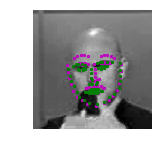

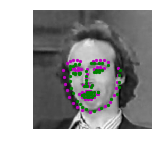

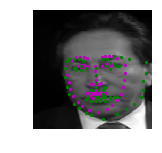

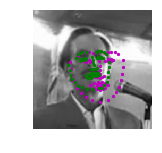

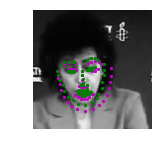

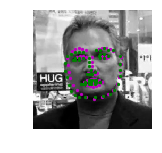

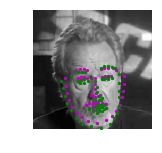

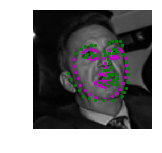

In [43]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=batch_size):

    for i in range(batch_size):
        plt.figure(figsize=(20,20))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
#         image = image.cpu()
        if gpu == True:
            image = image.cpu().numpy()
        else:
            image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        
        if gpu == True:
            predicted_key_pts = predicted_key_pts.cpu().numpy()
        
        else:
            predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [24]:
## TODO: Define the loss and optimization
import torch.optim as optim

# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.SmoothL1Loss()


optimizer = optim.Adam(params= net.parameters(), 
                         lr=0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [25]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
                
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            
            if gpu == True:                
                key_pts = key_pts.type(torch.FloatTensor).to(device)
                images = images.type(torch.FloatTensor).to(device)    
            else:
                key_pts = key_pts.type(torch.FloatTensor)#.to(device)
                images = images.type(torch.FloatTensor)#.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
        
            torch.cuda.empty_cache()
            
            
    print('Finished Training')


In [17]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.001781220942735672
Epoch: 1, Batch: 20, Avg. Loss: 0.0010269074738025665
Epoch: 1, Batch: 30, Avg. Loss: 0.0012837416157126427
Epoch: 1, Batch: 40, Avg. Loss: 0.0009593318924307823
Epoch: 1, Batch: 50, Avg. Loss: 0.0008957721590995789
Epoch: 1, Batch: 60, Avg. Loss: 0.0009196570478379727
Epoch: 1, Batch: 70, Avg. Loss: 0.0009707199260592461
Epoch: 1, Batch: 80, Avg. Loss: 0.00082884057238698
Epoch: 1, Batch: 90, Avg. Loss: 0.0010449720174074172
Epoch: 1, Batch: 100, Avg. Loss: 0.0010936735942959786
Epoch: 1, Batch: 110, Avg. Loss: 0.000926505584269762
Epoch: 1, Batch: 120, Avg. Loss: 0.0008364954330027103
Epoch: 1, Batch: 130, Avg. Loss: 0.0010896956771612168
Epoch: 1, Batch: 140, Avg. Loss: 0.0011056413277983664
Epoch: 1, Batch: 150, Avg. Loss: 0.001210098534822464
Epoch: 1, Batch: 160, Avg. Loss: 0.0011745732575654984
Epoch: 1, Batch: 170, Avg. Loss: 0.0009505548998713494
Epoch: 1, Batch: 180, Avg. Loss: 0.0009372158497571945
Epoch: 1, Batch: 190, Av

Epoch: 4, Batch: 220, Avg. Loss: 0.0008043886497616768
Epoch: 4, Batch: 230, Avg. Loss: 0.0008362335562705994
Epoch: 4, Batch: 240, Avg. Loss: 0.0007362226210534573
Epoch: 4, Batch: 250, Avg. Loss: 0.000750386094674468
Epoch: 4, Batch: 260, Avg. Loss: 0.0007258463762700557
Epoch: 4, Batch: 270, Avg. Loss: 0.0007046895734965801
Epoch: 4, Batch: 280, Avg. Loss: 0.0005691953413188458
Epoch: 4, Batch: 290, Avg. Loss: 0.0007122470960021019
Epoch: 4, Batch: 300, Avg. Loss: 0.0007978445664048194
Epoch: 4, Batch: 310, Avg. Loss: 0.0006896751653403043
Epoch: 4, Batch: 320, Avg. Loss: 0.0006600350886583329
Epoch: 4, Batch: 330, Avg. Loss: 0.0006287020407617092
Epoch: 4, Batch: 340, Avg. Loss: 0.000732554204761982
Epoch: 4, Batch: 350, Avg. Loss: 0.0007428641859441996
Epoch: 4, Batch: 360, Avg. Loss: 0.0005788515098392963
Epoch: 4, Batch: 370, Avg. Loss: 0.0006808591485023499
Epoch: 4, Batch: 380, Avg. Loss: 0.001014668133109808
Epoch: 4, Batch: 390, Avg. Loss: 0.0006960692740976811
Epoch: 4, Bat

Epoch: 7, Batch: 430, Avg. Loss: 0.0004719844181090593
Epoch: 8, Batch: 10, Avg. Loss: 0.0007145944982767105
Epoch: 8, Batch: 20, Avg. Loss: 0.0003691109362989664
Epoch: 8, Batch: 30, Avg. Loss: 0.0005481324065476655
Epoch: 8, Batch: 40, Avg. Loss: 0.0004896764680743218
Epoch: 8, Batch: 50, Avg. Loss: 0.0006465656254440546
Epoch: 8, Batch: 60, Avg. Loss: 0.0005151505004614592
Epoch: 8, Batch: 70, Avg. Loss: 0.0006700608376413584
Epoch: 8, Batch: 80, Avg. Loss: 0.0005626947805285454
Epoch: 8, Batch: 90, Avg. Loss: 0.000569404797628522
Epoch: 8, Batch: 100, Avg. Loss: 0.00046264148689806464
Epoch: 8, Batch: 110, Avg. Loss: 0.0004482403248548508
Epoch: 8, Batch: 120, Avg. Loss: 0.0005836923141032457
Epoch: 8, Batch: 130, Avg. Loss: 0.000466548727825284
Epoch: 8, Batch: 140, Avg. Loss: 0.0004435916617512703
Epoch: 8, Batch: 150, Avg. Loss: 0.0005049562584608793
Epoch: 8, Batch: 160, Avg. Loss: 0.0004716134201735258
Epoch: 8, Batch: 170, Avg. Loss: 0.0005265634767711163
Epoch: 8, Batch: 180

Epoch: 11, Batch: 190, Avg. Loss: 0.0003706171419471502
Epoch: 11, Batch: 200, Avg. Loss: 0.0003002728316932917
Epoch: 11, Batch: 210, Avg. Loss: 0.00031065358221530915
Epoch: 11, Batch: 220, Avg. Loss: 0.0005672479160130024
Epoch: 11, Batch: 230, Avg. Loss: 0.000297971285879612
Epoch: 11, Batch: 240, Avg. Loss: 0.0003098000790923834
Epoch: 11, Batch: 250, Avg. Loss: 0.00046169257909059523
Epoch: 11, Batch: 260, Avg. Loss: 0.00027162998914718626
Epoch: 11, Batch: 270, Avg. Loss: 0.0003474962767213583
Epoch: 11, Batch: 280, Avg. Loss: 0.00028206747584044934
Epoch: 11, Batch: 290, Avg. Loss: 0.00045122576877474783
Epoch: 11, Batch: 300, Avg. Loss: 0.0005167067181318998
Epoch: 11, Batch: 310, Avg. Loss: 0.00041850057709962127
Epoch: 11, Batch: 320, Avg. Loss: 0.0003441875223070383
Epoch: 11, Batch: 330, Avg. Loss: 0.000337065652012825
Epoch: 11, Batch: 340, Avg. Loss: 0.00031869539618492127
Epoch: 11, Batch: 350, Avg. Loss: 0.0003519031582400203
Epoch: 11, Batch: 360, Avg. Loss: 0.0003426

Epoch: 14, Batch: 370, Avg. Loss: 0.00034175002668052914
Epoch: 14, Batch: 380, Avg. Loss: 0.0006783557068556547
Epoch: 14, Batch: 390, Avg. Loss: 0.00035310384631156923
Epoch: 14, Batch: 400, Avg. Loss: 0.00038129076547920704
Epoch: 14, Batch: 410, Avg. Loss: 0.0003166027572005987
Epoch: 14, Batch: 420, Avg. Loss: 0.0004421653300523758
Epoch: 14, Batch: 430, Avg. Loss: 0.0002829718329012394
Epoch: 15, Batch: 10, Avg. Loss: 0.0002418284947052598
Epoch: 15, Batch: 20, Avg. Loss: 0.00035317460261285305
Epoch: 15, Batch: 30, Avg. Loss: 0.0003626539818942547
Epoch: 15, Batch: 40, Avg. Loss: 0.0002908800970762968
Epoch: 15, Batch: 50, Avg. Loss: 0.0005049369540065527
Epoch: 15, Batch: 60, Avg. Loss: 0.000520686125382781
Epoch: 15, Batch: 70, Avg. Loss: 0.00036353752575814724
Epoch: 15, Batch: 80, Avg. Loss: 0.0005271770805120468
Epoch: 15, Batch: 90, Avg. Loss: 0.00032565472461283207
Epoch: 15, Batch: 100, Avg. Loss: 0.0003113968186080456
Epoch: 15, Batch: 110, Avg. Loss: 0.0002780824601650

Epoch: 18, Batch: 120, Avg. Loss: 0.00039008769392967225
Epoch: 18, Batch: 130, Avg. Loss: 0.0003225039727985859
Epoch: 18, Batch: 140, Avg. Loss: 0.00043717486318200826
Epoch: 18, Batch: 150, Avg. Loss: 0.0005594708351418376
Epoch: 18, Batch: 160, Avg. Loss: 0.0004298035930842161
Epoch: 18, Batch: 170, Avg. Loss: 0.00028942093346267936
Epoch: 18, Batch: 180, Avg. Loss: 0.0003241471517831087
Epoch: 18, Batch: 190, Avg. Loss: 0.0003296172898262739
Epoch: 18, Batch: 200, Avg. Loss: 0.00047401587292551995
Epoch: 18, Batch: 210, Avg. Loss: 0.0003224363960325718
Epoch: 18, Batch: 220, Avg. Loss: 0.0003706189524382353
Epoch: 18, Batch: 230, Avg. Loss: 0.00036610171012580394
Epoch: 18, Batch: 240, Avg. Loss: 0.00022387637011706828
Epoch: 18, Batch: 250, Avg. Loss: 0.000318693027831614
Epoch: 18, Batch: 260, Avg. Loss: 0.0003180458014830947
Epoch: 18, Batch: 270, Avg. Loss: 0.0003877082392573357
Epoch: 18, Batch: 280, Avg. Loss: 0.00045065201073884965
Epoch: 18, Batch: 290, Avg. Loss: 0.000437

Epoch: 21, Batch: 300, Avg. Loss: 0.00033262759819626807
Epoch: 21, Batch: 310, Avg. Loss: 0.00022967732883989812
Epoch: 21, Batch: 320, Avg. Loss: 0.00036684986390173437
Epoch: 21, Batch: 330, Avg. Loss: 0.0004992902223020792
Epoch: 21, Batch: 340, Avg. Loss: 0.0004953026538714767
Epoch: 21, Batch: 350, Avg. Loss: 0.0003455645628273487
Epoch: 21, Batch: 360, Avg. Loss: 0.00022765242401510477
Epoch: 21, Batch: 370, Avg. Loss: 0.00023172847833484412
Epoch: 21, Batch: 380, Avg. Loss: 0.00025987664610147476
Epoch: 21, Batch: 390, Avg. Loss: 0.0004385960064828396
Epoch: 21, Batch: 400, Avg. Loss: 0.0002983613759279251
Epoch: 21, Batch: 410, Avg. Loss: 0.0003640362247824669
Epoch: 21, Batch: 420, Avg. Loss: 0.0002486486863344908
Epoch: 21, Batch: 430, Avg. Loss: 0.0002871281113475561
Epoch: 22, Batch: 10, Avg. Loss: 0.00027754235360771416
Epoch: 22, Batch: 20, Avg. Loss: 0.00029959050472825764
Epoch: 22, Batch: 30, Avg. Loss: 0.00025990706495940686
Epoch: 22, Batch: 40, Avg. Loss: 0.0003237

Epoch: 25, Batch: 40, Avg. Loss: 0.0002548654619604349
Epoch: 25, Batch: 50, Avg. Loss: 0.00031759349070489406
Epoch: 25, Batch: 60, Avg. Loss: 0.0003939734045416117
Epoch: 25, Batch: 70, Avg. Loss: 0.0003047585394233465
Epoch: 25, Batch: 80, Avg. Loss: 0.00036058929562568666
Epoch: 25, Batch: 90, Avg. Loss: 0.0003086358066648245
Epoch: 25, Batch: 100, Avg. Loss: 0.00029858217760920527
Epoch: 25, Batch: 110, Avg. Loss: 0.00022302494570612907
Epoch: 25, Batch: 120, Avg. Loss: 0.0003821985023096204
Epoch: 25, Batch: 130, Avg. Loss: 0.0004510848661884665
Epoch: 25, Batch: 140, Avg. Loss: 0.0002733363574370742
Epoch: 25, Batch: 150, Avg. Loss: 0.00030737019237130883
Epoch: 25, Batch: 160, Avg. Loss: 0.00027782223746180537
Epoch: 25, Batch: 170, Avg. Loss: 0.00034733041934669015
Epoch: 25, Batch: 180, Avg. Loss: 0.00033028591983020304
Epoch: 25, Batch: 190, Avg. Loss: 0.0003136760741472244
Epoch: 25, Batch: 200, Avg. Loss: 0.0002751796348020434
Epoch: 25, Batch: 210, Avg. Loss: 0.0003935969

Epoch: 28, Batch: 210, Avg. Loss: 0.0003578017307445407
Epoch: 28, Batch: 220, Avg. Loss: 0.0002775690723210573
Epoch: 28, Batch: 230, Avg. Loss: 0.00022895523626357316
Epoch: 28, Batch: 240, Avg. Loss: 0.00039607014507055284
Epoch: 28, Batch: 250, Avg. Loss: 0.00022757787443697454
Epoch: 28, Batch: 260, Avg. Loss: 0.0003146443627774715
Epoch: 28, Batch: 270, Avg. Loss: 0.0002973216995596886
Epoch: 28, Batch: 280, Avg. Loss: 0.0002912811152637005
Epoch: 28, Batch: 290, Avg. Loss: 0.00026542502269148824
Epoch: 28, Batch: 300, Avg. Loss: 0.0003327859118580818
Epoch: 28, Batch: 310, Avg. Loss: 0.00026531585957854985
Epoch: 28, Batch: 320, Avg. Loss: 0.00023059474118053913
Epoch: 28, Batch: 330, Avg. Loss: 0.00030118655972182753
Epoch: 28, Batch: 340, Avg. Loss: 0.00027374673169106245
Epoch: 28, Batch: 350, Avg. Loss: 0.00024755673110485077
Epoch: 28, Batch: 360, Avg. Loss: 0.0002988651823252439
Epoch: 28, Batch: 370, Avg. Loss: 0.00031593015789985657
Epoch: 28, Batch: 380, Avg. Loss: 0.00

Epoch: 31, Batch: 380, Avg. Loss: 0.00033646046556532383
Epoch: 31, Batch: 390, Avg. Loss: 0.00023678232729434966
Epoch: 31, Batch: 400, Avg. Loss: 0.0003734913729131222
Epoch: 31, Batch: 410, Avg. Loss: 0.0002716877162456512
Epoch: 31, Batch: 420, Avg. Loss: 0.00040978165809065105
Epoch: 31, Batch: 430, Avg. Loss: 0.00030638633389025926
Epoch: 32, Batch: 10, Avg. Loss: 0.00038219520822167395
Epoch: 32, Batch: 20, Avg. Loss: 0.0002636125450953841
Epoch: 32, Batch: 30, Avg. Loss: 0.00029960766062140466
Epoch: 32, Batch: 40, Avg. Loss: 0.0003600885216146708
Epoch: 32, Batch: 50, Avg. Loss: 0.0002662285501137376
Epoch: 32, Batch: 60, Avg. Loss: 0.000251774319447577
Epoch: 32, Batch: 70, Avg. Loss: 0.0002451817328110337
Epoch: 32, Batch: 80, Avg. Loss: 0.00027113642450422046
Epoch: 32, Batch: 90, Avg. Loss: 0.00024558813031762836
Epoch: 32, Batch: 100, Avg. Loss: 0.00034401789493858814
Epoch: 32, Batch: 110, Avg. Loss: 0.00025883700884878633
Epoch: 32, Batch: 120, Avg. Loss: 0.000559314467

Epoch: 35, Batch: 120, Avg. Loss: 0.0007742808246985077
Epoch: 35, Batch: 130, Avg. Loss: 0.0002828629668802023
Epoch: 35, Batch: 140, Avg. Loss: 0.00022164878528565168
Epoch: 35, Batch: 150, Avg. Loss: 0.0005288281803950668
Epoch: 35, Batch: 160, Avg. Loss: 0.0003246383918449283
Epoch: 35, Batch: 170, Avg. Loss: 0.0003576946035027504
Epoch: 35, Batch: 180, Avg. Loss: 0.0002981510777026415
Epoch: 35, Batch: 190, Avg. Loss: 0.0002532040160149336
Epoch: 35, Batch: 200, Avg. Loss: 0.0002705921791493893
Epoch: 35, Batch: 210, Avg. Loss: 0.0004152243100106716
Epoch: 35, Batch: 220, Avg. Loss: 0.00028038134053349497
Epoch: 35, Batch: 230, Avg. Loss: 0.00038362507056444883
Epoch: 35, Batch: 240, Avg. Loss: 0.00031912888400256636
Epoch: 35, Batch: 250, Avg. Loss: 0.0003834183607250452
Epoch: 35, Batch: 260, Avg. Loss: 0.00033759999834001065
Epoch: 35, Batch: 270, Avg. Loss: 0.00029664587788283826
Epoch: 35, Batch: 280, Avg. Loss: 0.0003325810469686985
Epoch: 35, Batch: 290, Avg. Loss: 0.000357

Epoch: 38, Batch: 290, Avg. Loss: 0.0002808147184550762
Epoch: 38, Batch: 300, Avg. Loss: 0.00024666586332023146
Epoch: 38, Batch: 310, Avg. Loss: 0.00029145226161926985
Epoch: 38, Batch: 320, Avg. Loss: 0.0002910951767116785
Epoch: 38, Batch: 330, Avg. Loss: 0.0002914318349212408
Epoch: 38, Batch: 340, Avg. Loss: 0.00048029491491615773
Epoch: 38, Batch: 350, Avg. Loss: 0.00034051343612372874
Epoch: 38, Batch: 360, Avg. Loss: 0.0002957355696707964
Epoch: 38, Batch: 370, Avg. Loss: 0.0003710854947566986
Epoch: 38, Batch: 380, Avg. Loss: 0.00021999843046069146
Epoch: 38, Batch: 390, Avg. Loss: 0.0002856335444375873
Epoch: 38, Batch: 400, Avg. Loss: 0.00029107772558927534
Epoch: 38, Batch: 410, Avg. Loss: 0.00024352732580155135
Epoch: 38, Batch: 420, Avg. Loss: 0.0006073147347196937
Epoch: 38, Batch: 430, Avg. Loss: 0.000423415252007544
Epoch: 39, Batch: 10, Avg. Loss: 0.0002323334952816367
Epoch: 39, Batch: 20, Avg. Loss: 0.00028316850308328866
Epoch: 39, Batch: 30, Avg. Loss: 0.00060757

Epoch: 42, Batch: 30, Avg. Loss: 0.000273488980717957
Epoch: 42, Batch: 40, Avg. Loss: 0.0006013576108962297
Epoch: 42, Batch: 50, Avg. Loss: 0.00021009322628378867
Epoch: 42, Batch: 60, Avg. Loss: 0.00026459500566124915
Epoch: 42, Batch: 70, Avg. Loss: 0.0002738010045140982
Epoch: 42, Batch: 80, Avg. Loss: 0.00031445011403411627
Epoch: 42, Batch: 90, Avg. Loss: 0.0005407396079972386
Epoch: 42, Batch: 100, Avg. Loss: 0.00021408843621611596
Epoch: 42, Batch: 110, Avg. Loss: 0.00027496931422501804
Epoch: 42, Batch: 120, Avg. Loss: 0.00028942436911165713
Epoch: 42, Batch: 130, Avg. Loss: 0.00038167649880051615
Epoch: 42, Batch: 140, Avg. Loss: 0.0002480423953384161
Epoch: 42, Batch: 150, Avg. Loss: 0.0003302722154185176
Epoch: 42, Batch: 160, Avg. Loss: 0.00019122846331447364
Epoch: 42, Batch: 170, Avg. Loss: 0.0003223898308351636
Epoch: 42, Batch: 180, Avg. Loss: 0.0003305044015869498
Epoch: 42, Batch: 190, Avg. Loss: 0.0002428060956299305
Epoch: 42, Batch: 200, Avg. Loss: 0.000260123828

Epoch: 45, Batch: 200, Avg. Loss: 0.00024126740824431182
Epoch: 45, Batch: 210, Avg. Loss: 0.0002834576377645135
Epoch: 45, Batch: 220, Avg. Loss: 0.00037291755340993404
Epoch: 45, Batch: 230, Avg. Loss: 0.00021978401578962804
Epoch: 45, Batch: 240, Avg. Loss: 0.00019726214837282897
Epoch: 45, Batch: 250, Avg. Loss: 0.0003079964676871896
Epoch: 45, Batch: 260, Avg. Loss: 0.00030199694167822597
Epoch: 45, Batch: 270, Avg. Loss: 0.000335277646780014
Epoch: 45, Batch: 280, Avg. Loss: 0.0003227733802050352
Epoch: 45, Batch: 290, Avg. Loss: 0.0002703184969723225
Epoch: 45, Batch: 300, Avg. Loss: 0.00030902665853500366
Epoch: 45, Batch: 310, Avg. Loss: 0.0002066436754539609
Epoch: 45, Batch: 320, Avg. Loss: 0.0003129099039360881
Epoch: 45, Batch: 330, Avg. Loss: 0.00027334018237888815
Epoch: 45, Batch: 340, Avg. Loss: 0.0002527376990765333
Epoch: 45, Batch: 350, Avg. Loss: 0.000188111649826169
Epoch: 45, Batch: 360, Avg. Loss: 0.000259589247405529
Epoch: 45, Batch: 370, Avg. Loss: 0.00018851

Epoch: 48, Batch: 370, Avg. Loss: 0.00023052178137004375
Epoch: 48, Batch: 380, Avg. Loss: 0.0002673525046557188
Epoch: 48, Batch: 390, Avg. Loss: 0.00030089346412569284
Epoch: 48, Batch: 400, Avg. Loss: 0.0002890873029828072
Epoch: 48, Batch: 410, Avg. Loss: 0.00037210590951144697
Epoch: 48, Batch: 420, Avg. Loss: 0.0001860974421724677
Epoch: 48, Batch: 430, Avg. Loss: 0.0003074472490698099
Epoch: 49, Batch: 10, Avg. Loss: 0.00023017270397394896
Epoch: 49, Batch: 20, Avg. Loss: 0.00021697381045669318
Epoch: 49, Batch: 30, Avg. Loss: 0.0004939745105803012
Epoch: 49, Batch: 40, Avg. Loss: 0.0002513311803340912
Epoch: 49, Batch: 50, Avg. Loss: 0.0002296099131926894
Epoch: 49, Batch: 60, Avg. Loss: 0.00023763925209641456
Epoch: 49, Batch: 70, Avg. Loss: 0.00019584439974278212
Epoch: 49, Batch: 80, Avg. Loss: 0.0002684782650321722
Epoch: 49, Batch: 90, Avg. Loss: 0.0003454365804791451
Epoch: 49, Batch: 100, Avg. Loss: 0.00022248450666666032
Epoch: 49, Batch: 110, Avg. Loss: 0.0003253359878

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [27]:
import torch
import torch
from models import Net

model_dir = 'saved_models/'
model_name = 'keypoints_model_BEST.pt'

net = Net()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu = None

if torch.cuda.is_available():
    gpu = True
    print("Using GPU: ", gpu)
    net.load_state_dict(torch.load(model_dir+model_name))
    net.to(device)
    net.eval()
else:
    print("Using GPU: ",gpu)

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load(model_dir+model_name))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()
# net = torch.load(model_dir+model_name)
# net.net_sample_output()

Using GPU:  True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dp1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dp2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dp3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (dp4): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (dp5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (dp6): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu = None

if torch.cuda.is_available():
    gpu = True
    print("Using GPU: ", gpu)
else:
    print("Using GPU: ",gpu)


Using GPU:  True


In [28]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())



torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


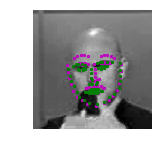

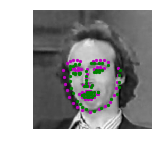

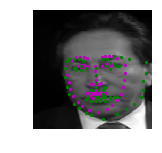

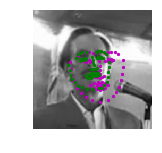

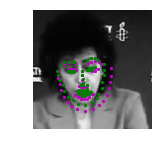

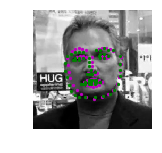

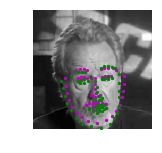

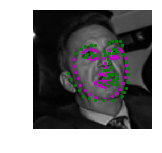

In [44]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
# for i in range(10):
visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_BEST.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I am following the research paper given above to learn more about facial key point detection. As the paper suggests, Adam optimizer with learning rate 0.001 to minimize MSE. Due to same reference, applied MSE initially.

Reseach paper: https://arxiv.org/pdf/1710.00977.pdf

Later, I also tried suggested loss functions. 
 - MSE and L1 was same and Loss did not go below ~0.0066 for first 2 epochs. 
 - With SmoothL1Loss, for the first 2 epochs, loss were around 0.0026. So, decided to choose **SmoothL1Loss**.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

 - I started with an architecture with 3 convolution layers, single fully connected layer and a single dropout layer. 
 - Later, implemented 4 conv layers, 3 fully conected layers and dropout after every convolution and fully connected layer. 
     - Dropout rate:
     - 0.1 to 0.6 
 - Created a similar model as "NaimishNet" mentioned in the paper.
     - 

        **Layers details:**

| Layer name | Number of Filters | Size/ rate |
| --- | --- | --- |
| conv1 | 32 | (5,5) |
| pool | --- | (2,2) |
| dropout1 | --- | 10 % |
| conv2 | 64 | (3,3) |
| dropout2 | --- | 20% |
| conv3 | 128 | (3,3) |
| dropout3 | --- | 30% |
| conv4 | 256 | (2,2) |
| dropout4 | --- | 40% |
| fc1 | --- | (36864, 1000) |
| dropout5 | --- | 50% |
| fc2 | --- | (1000, 1000) |
| dropout6 | --- | 60% |
| fc3 | --- | (1000, 136) |


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I started to work on this notebook on my own machine with 1 epoch and batch_size 10, But my rationale to select the size depends on below. 

The  process was taking quite longer, that it swhy I decided to train the model in workspace. 

**Epochs:**

 - Epoch 1 : Training was finished and model was saved. So, I decided to increaase the number of epochs to 10. 
 - Epoch 10 : Tried several times for last 2 days, and the training keep failing.
 - Epoch 3 : After several unsuccessful attempts, Decided to keep "n_epochs=3"

**Batch Size:**

 - Batch size 10 : Training started, however it was quite slow. To make the process faster, increased the batch size.
 - Batch size 128 : Error "RuntimeError: DataLoader worker (pid 219) is killed by signal: Bus error.
"
 - Batch size 64 : Error: "RuntimeError: DataLoader worker (pid 219) is killed by signal: Bus error.
"

**Soution of the above error: Changed the n_workers to 0** 
 - Batch size 128 : This is taking longer than 20 minutes, therefore changing it to 32
 
 **Moved back to Local Machine**
 
 - Also, had an error on the workspace, and changed network architecture to work on on. After setting up an architecture, did experimentation with batch_size. started with 64. but the GPU did not had enough memory. After few trial and error batch_size 8 worked better. 
 
 - For the epoch, initially started with 1, and 10 epoch. Loss was going down gradually and steadily. My atch_size was
 small I decided to train the model for more epochs.
 - As I was training my model on my own machine, I did not had an issue with a longer training process and decided to train it for 50 epochs. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.07042655  0.00474423  0.08943427  0.03750923 -0.03182244]
 [-0.19789828 -0.06824807 -0.18194942 -0.06973752 -0.06769402]
 [-0.02848388  0.10415688  0.12221517  0.0502176   0.05151625]
 [ 0.08843189 -0.00469434  0.02656914 -0.0094932  -0.22185172]
 [-0.05763921  0.09238208 -0.25796434  0.04026887 -0.14993137]]
(5, 5)


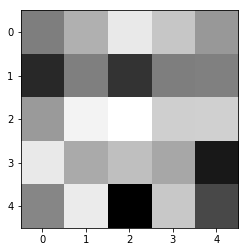

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data.cpu()

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

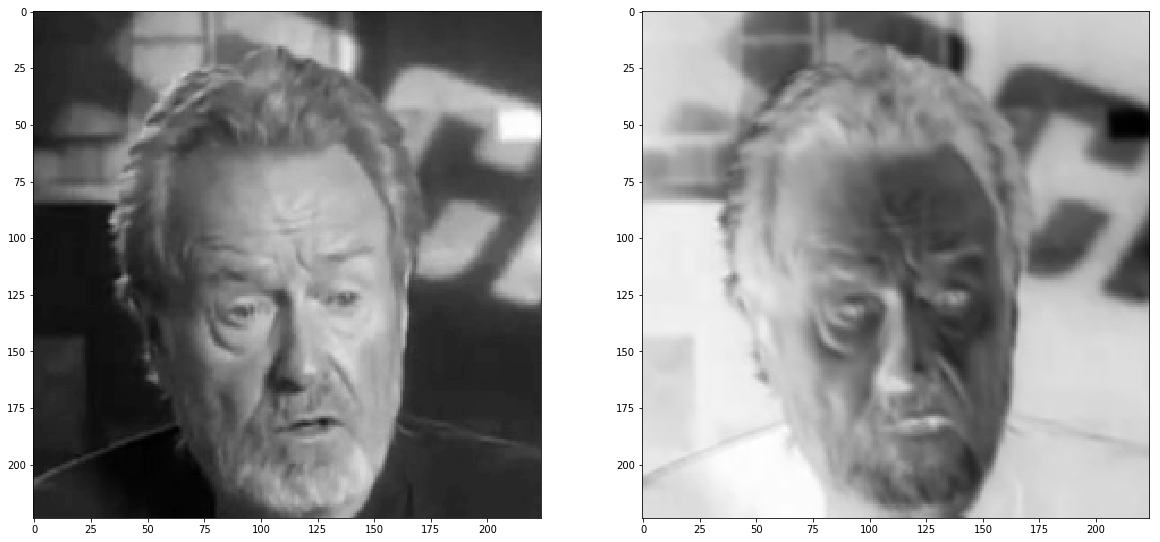

In [66]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


import cv2
import random, os

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

img = test_images[6].data
img = img.cpu().numpy()
img = np.transpose(img, (1, 2, 0))
plt.imshow(np.squeeze(img), cmap='gray')

plt.subplot(1,2,2)
weights = net.conv3.weight.data
w = weights.cpu().numpy()
c = cv2.filter2D(img, -1, w[0][0])
plt.imshow(c, cmap='gray')


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

- It detects some of the vertical lines and the image is blurred and an inverted image. As, the image is smoothened it deteting the edges in the image and detect high level features.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!